<a href="https://colab.research.google.com/github/dajebbar/AI-Programming-with-python/blob/main/Amazon_Fine_Food_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>



The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a *review*, **determine** whether the review is **positive** (Rating of 4 or 5) or **negative** (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

from google.colab import drive
drive.mount('/content/gdrive')

from IPython.display import YouTubeVideo, Image

plt.style.use('fivethirtyeight')
%matplotlib inline

Mounted at /content/gdrive


## Loading the data

Since I chose to work on google colab I will import the dataset directly from kaggle.

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import  files
# Saving kaggle.json
# files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# change the permission
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d snap/amazon-fine-food-reviews

amazon-fine-food-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
from zipfile import ZipFile
file_name = "amazon-fine-food-reviews.zip"

with ZipFile(file_name, 'r') as zp:
  zp.extractall()
  print('done')

done


The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

# [1]. Reading Data
using the SQLite Table to read data.

In [ ]:
con = sqlite3.connect('/content/database.sqlite')

Filtering only positive and negative reviews i.e. 
not taking into consideration those reviews with Score=3

In [ ]:
filtered_data = pd.read_sql_query("""select * from Reviews where Score != 3""", con)

# changing reviews with score less the 3 to be negative(0) and more than 3
# to be positive(1)

filtered_data.loc[:, 'Score'] = filtered_data.loc[:, 'Score'].map(lambda x: 1 if x > 3 else 0)
print(f"Number of datapoints: {filtered_data.shape}")
filtered_data.head()


Number of datapoints: (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## [2] Data Cleaning: Deduplication

Now let's try to see if our dataset contains any duplicate entries

In [ ]:
display = pd.read_sql("""
select ProductId, UserId, ProfileName, Score, Time,
Text, count(*) as deduplication_cnt from Reviews
group by UserId having deduplication_cnt > 1
""", con)


print(display.shape)
display.head()

(80668, 7)


,ProductId,UserId,ProfileName,Score,Time,Text,deduplication_cnt
0,B007Y59HVM,#oc-R115TNMSPFT9I7,Breyton,2,1331510400,Overall its just OK when considering the price...,2
1,B005HG9ET0,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",5,1342396800,"My wife has recurring extreme muscle spasms, u...",3
2,B007Y59HVM,#oc-R11DNU2NBKQ23Z,Kim Cieszykowski,1,1348531200,This coffee is horrible and unfortunately not ...,2
3,B005HG9ET0,#oc-R11O5J5ZVQE25C,Penguin Chick,5,1346889600,This will be the bottle that you grab from the...,3
4,B007OSBE1U,#oc-R12KPBODL2B5ZD,Christopher P. Presta,1,1348617600,I didnt like this coffee. Instead of telling y...,2


In [ ]:
display['deduplication_cnt'].sum()

393063

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)

display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [ ]:
# sorting data according to productID ascending order
sorted_data = filtered_data.sort_values(by='ProductId',ascending=True, 
                                       axis=0, inplace=False,
                                       kind='quicksort', na_position='last')

In [ ]:
#Deduplication of entries
final = sorted_data.drop_duplicates(subset={
    "UserId","ProfileName","Time","Text"
}, keep='first', inplace=False)

final.shape

(364173, 10)

In [ ]:
#Checking to see how much % of data still remains
final.shape[0] / filtered_data.shape[0] *100.0

69.25890143662969

We can see that we have lost more than **30% of our data.**

Let's continue our data cleaning, knowing that this step is based on common sense and there is no basic rule that must be taken to succeed in this task. we could check for example if the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible.

HelpfulnessDenominator = HelpfulnessNumerator + NO

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND 
HelpfulnessNumerator > HelpfulnessDenominator
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [ ]:
# Let's remove them

final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]
final.shape

(364171, 10)

Let's check how many positive and negative reviews are present in our dataset

In [ ]:
np.round(final.loc[:,'Score'].value_counts(normalize=True), 3) * 100

1    84.3
0    15.7
Name: Score, dtype: float64

We see that we have an *imbalanced* dataset positive values > negative values 84:16

Now our data is ready for **Text processing**, before moving, let's pickle it for later use

In [ ]:
import pickle

final.to_pickle('data_before_possecing.pkl')

# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews.

Our goal is to go from a **raw text** to a **vector** form so that we can apply the full **power of linear algebra**.
So the text pre-processing phase will allow us to make the data more cleaner.

In [ ]:
# let's print some random review

sent_0 = final.loc[:,'Text'].values[0]
print(sent_0)
print("="*50)

sent_1 = final.loc[:,'Text'].values[1]
print(sent_1)
print("="*50)

sent_500 = final.loc[:,'Text'].values[500]
print(sent_500)
print("="*50)

sent_1000 = final.loc[:,'Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final.loc[:,'Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final.loc[:,'Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.
As many other reviewers have suggested, the best way to use this trap is NOT to bury it, just simply tamp the ground over the tunnel and make 2 slots for the jaws of the trap. It never misses, when it trips, you have one less critter ruining your lawn!
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste

We can easily see that our data contains numbers, punctuation, html tags ... For that we will need to import the re library of python which allows to execute operations on regular expressions (Regex) as well as the beautifulsoup library which allows you to parse html documents.

In [ ]:
import re
import bs4 as bs

Before continuing on the whole document, let's do some demonstrations

In [ ]:
string = "Why is this $[...] when the same product is available for \
$[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor \
M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby."

# remove urls from text
print(string)
print('=='*50)
pattern = re.compile(r'https?\S+')
string = re.sub(pattern, '', string)
print(string)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [ ]:
# remove html tags
soup = bs.BeautifulSoup(string, 'lxml')
text = soup.get_text()
print(string)
print('=='*50)
print(text)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


The English language has a couple of contractions. For instance:

you've -> you have

he's -> he is

These can sometimes cause headache when you are doing natural language processing.


In [ ]:
# let's make a function that clarify it
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
string_ = "Hey, I'm sorry; but these reviews do nobody any good beyond reminding us to look  before ordering."

print(string_)

string_ = decontracted(string_)
print(string)


Hey, I'm sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.
Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [ ]:
#remove words with numbers
print(string)
print('==' * 50)
string = re.sub("\S*\d\S*", "", string).strip()
print(string)


Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [ ]:
# remove special caracteres
print(string)
print('=='*50)
string = re.sub('[^A-Za-z0-9]+', ' ', string)
print(string)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
Why is this when the same product is available for here br br The Victor and traps are unreal of course total fly genocide Pretty stinky but only right nearby 


In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

### Now let's combine all the above:

In [ ]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar

import bs4 as bs
import re

for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = bs.BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [01:44<00:00, 3475.59it/s]


In [ ]:
# We capture our own data in a new dataframe and save it in pickle 
# form for later use. Note that we can be satisfied with the preprocessed_reviews list.

data_clean = pd.DataFrame(preprocessed_reviews)
data_clean = data_clean.rename(columns={0:'Text'})

# let's pickle it
data_clean.to_pickle('corpus.pkl')


In [ ]:
data_clean.loc[:, 'Text'].values[52]

'two dogs love product love fact not loaded chemical preservatives fillers fact pieces irregular not drawback not surprising cut larger pieces not want give much prospect getting one treats makes much receptive training coming call also find largest size economical not pay shipping'

# [4] Featurization

Now that we have our a collection of text **corpus** let's convert it to vectors.
## [4.1] BAG OF WORDS
BoW's technique consists of creating a lexical dictionary containing a set of all the words in the reviews.


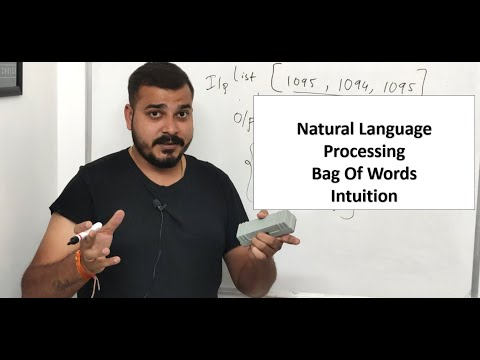

In [ ]:
YouTubeVideo(id="IKgBLTeQQL8", width=950, height=450)

### Document-Term Matrix

For many of the techniques we'll be using in future notebooks, the text must be tokenized, meaning broken down into smaller pieces. The most common tokenization technique is to break down text into words. We can do this using scikit-learn's CountVectorizer, where every row will represent a different document and every column will represent a different word.

In [ ]:
# We are going to create a document-term matrix using CountVectorizer,
# and exclude common English stop words

from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
data_cv = cv.fit_transform(data_clean.Text)


print("the type of count vectorizer ",type(data_cv))

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>


We see that our return object is a sparse matrix.

## What is a sparse matrix?

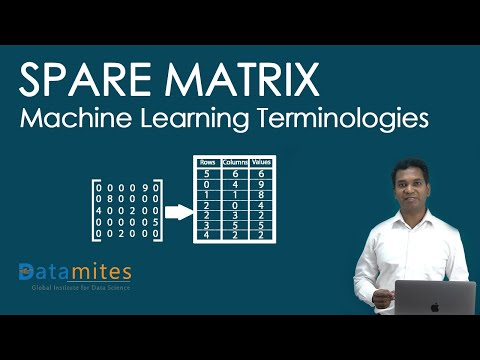

In [ ]:
YouTubeVideo(id="4MoSrMkWovM", width=950, height=450)

In [ ]:
print("the shape of out text BOW vectorizer ", data_cv.get_shape())
print("the number of unique words ", data_cv.get_shape()[1])

the shape of out text BOW vectorizer  (364171, 116756)
the number of unique words  116756


In [ ]:
print("some feature names ", cv.get_feature_names()[:10])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaa', 'aaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaa']


In [ ]:
# let's pickle it
pickle.dump(cv, open("cv.pkl", "wb"))

### What is Tokenization?

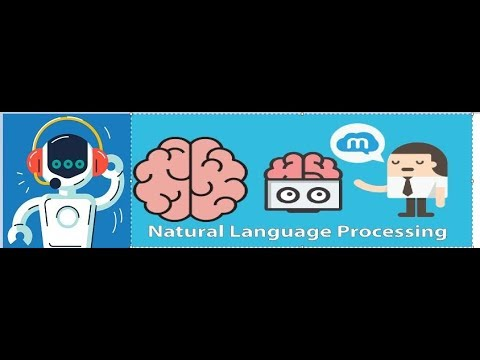

In [ ]:
YouTubeVideo(id="6ZVf1jnEKGI", width=950, height=450)

### What is stemming and lemmatization

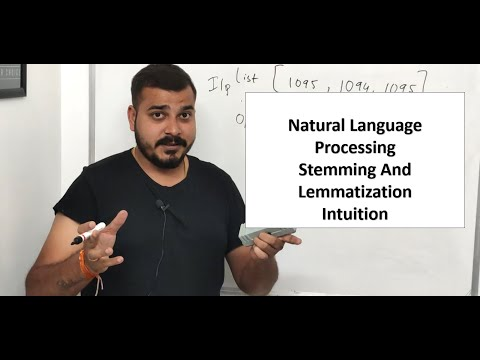

In [ ]:
YouTubeVideo(id="JpxCt3kvbLk", width=950, height=450)

## [4.2] Bi-Grams and n-Grams

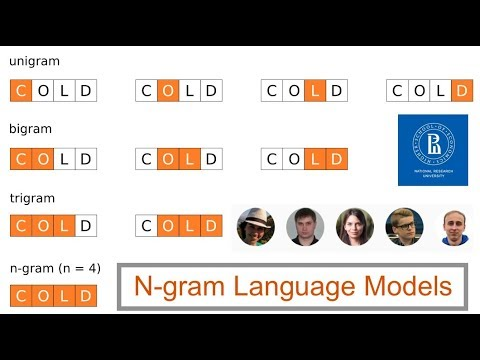

In [ ]:
YouTubeVideo(id="GiyMGBuu45w", width=950, height=450)

In [ ]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = cv.fit_transform(data_clean.Text)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (364171, 116756)
the number of unique words including both unigrams and bigrams  116756


## [4.3] TF-IDF

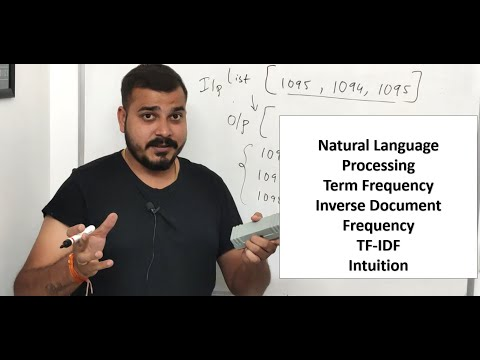

In [ ]:
YouTubeVideo(id="D2V1okCEsiE", width=950, height=450)

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer


tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(data_clean.Text)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(data_clean.Text)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aaa', 'aaaaa', 'aaah', 'aafco', 'ab', 'aback', 'abandon', 'abandoned', 'abbey']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (364171, 203034)
the number of unique words including both unigrams and bigrams  203034


## [4.4] Word2Vec

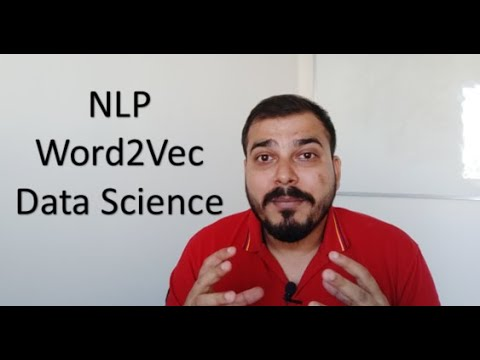

In [ ]:
YouTubeVideo(id="Otde6VGvhWM", width=950, height=450)

### Train your own Word2Vec model using your own text corpus

In [ ]:
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

### Using Google News Word2Vectors

A pretrained model by google
its 3.3G file, once you load this into your memory 
it occupies ~9Gb, so please do this step only if you have >12G of ram
To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
it's 1.9GB in size.


In [ ]:
# s_your_ram_gt_16g=False
# want_to_use_google_w2v = False
# want_to_train_w2v = True
# if want_to_use_google_w2v and is_your_ram_gt_16g:
#     if os.path.isfile('GoogleNews-vectors-negative300.bin'):
#         w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
#         print(w2v_model.wv.most_similar('great'))
#         print(w2v_model.wv.most_similar('worst'))
#     else:
#         print("you don't have google's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")


In [ ]:
# if want_to_train_w2v:
# min_count = 5 considers only words that occured atleast 5 times

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)

print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))

[('fantastic', 0.8839952349662781), ('terrific', 0.8722715973854065), ('awesome', 0.8611624836921692), ('good', 0.8570479154586792), ('excellent', 0.8478260040283203), ('wonderful', 0.8195714950561523), ('perfect', 0.7781842350959778), ('fabulous', 0.7639541625976562), ('nice', 0.7454850077629089), ('amazing', 0.7205305695533752)]
[('nastiest', 0.8558255434036255), ('greatest', 0.7720641493797302), ('best', 0.7365351319313049), ('disgusting', 0.7232356667518616), ('terrible', 0.7169737815856934), ('horrible', 0.7039061784744263), ('tastiest', 0.6941503286361694), ('awful', 0.6802276968955994), ('nicest', 0.6681916117668152), ('vile', 0.6658698916435242)]


In [ ]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  33573
sample words  ['witty', 'little', 'book', 'makes', 'son', 'laugh', 'loud', 'recite', 'car', 'driving', 'along', 'always', 'sing', 'refrain', 'learned', 'whales', 'india', 'drooping', 'roses', 'love', 'new', 'words', 'introduces', 'silliness', 'classic', 'willing', 'bet', 'still', 'able', 'memory', 'college', 'grew', 'reading', 'sendak', 'books', 'watching', 'really', 'rosie', 'movie', 'incorporates', 'loves', 'however', 'miss', 'hard', 'cover', 'version', 'seem', 'kind', 'flimsy', 'takes']


## [4.4.1] Converting text into vectors using wAvg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 364171/364171 [16:29<00:00, 367.86it/s]

364171
50


#### [4.4.1.2] TFIDF weighted W2v

In [ ]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 364171/364171 [4:28:57<00:00, 22.57it/s]
